# **Performance of clustering methods**
This notebook can be used to recreate the paper's figure about ClusTCR's performance, benchmarked against existing clustering approaches. To use the notebook, clone *clusTCR*'s github repository ([https://github.com/svalkiers/clusTCR](https://github.com/svalkiers/clusTCR)) onto your device and pasting the path to the repo down here.

In [4]:
import os

# Path to clusTCR repo goes here:
os.chdir('/path_to_repo/clusTCR/')

Import all dependencies

In [2]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

from clustcr import Clustering, datasets
from clustcr.modules.gliph2.gliph2 import GLIPH2
from clustcr.modules.ismart.ismart import iSMART
from tcrdist.repertoire import TCRrep

Figure aesthetics

In [3]:
plt.style.use(['seaborn-white', 'seaborn-paper'])
plt.rc('font', family='serif')
sns.set_palette('Set1')
sns.set_context('paper', font_scale=1.3)

Parameters.

In [ ]:
sample_sizes = [5000,
               10000,
               25000,
               50000,
               100000,
               200000,
               500000,
               750000,
               1000000]

data_directory = '/home/path_to_data/'

## **Assess algorithmic runtime**

In [1]:
result = {'GLIPH2':[],
         'iSMART':[],
         'ClusTCR¹':[],
         'ClusTCR²':[],
         'TCRDist*':[],
         'n_sequences':[]}

for s in sample_sizes:
    result['n_sequences'].append(s)

    # ClusTCR data
    metarepertoire = datasets.metarepertoire(directory=data_directory,
                                             data_format='immuneaccess',
                                             out_format='CDR3',
                                             n_sequences=s)
    # clusTCR @ 8 CPUs
    t0 = time.time()
    ts = Clustering(n_cpus=8)
    ts.fit(metarepertoire)
    t1 = time.time()
    t = t1 - t0
    result['clusTCR'].append(t)
    print('Clustered %s sequences with clusTCR in %s minutes.' % (s, t/60))


    # GLIPH2
    metarepertoire = datasets.metarepertoire(directory=data_directory,
                                             data_format='immuneaccess',
                                             out_format='GLIPH2',
                                             n_sequences=s)
    c, t = GLIPH2(metarepertoire)
    result['GLIPH2'].append(t)
    
    # iSMART -> kernel errors appear for data set sizes > 200K
    # Therefore, skip iSMART for instances where n(seq) > 200K
    if s > 200000:
        result['iSMART'].append(None)
    else:
        c, t = iSMART(metarepertoire)
        result['iSMART'].append(t)
    
    # TCRDist -> kernel errors appear for data set sizes > 200K
    # Therefore, skip TCRDist for instances where n(seq) > 200K
    if s >= 200000:
        result['TCRDist*'].append(None)
    else:
        metarepertoire = datasets.metarepertoire(directory=data_directory,
                                                 data_format='immuneaccess',
                                                 out_format='tcrdist',
                                                 n_sequences=s)
        c, t = tcrdist(metarepertoire)
        result['TCRDist*'].append(t)

    pd.DataFrame(result).to_csv('./results/method_comparison_speed.tsv', sep='\t')

## **Plot results**

Read speed benchmarking results and select entries corresponding to <= 1M sequences. 

In [31]:
# Read data
data = pd.read_csv('results/method_comparison_speed.tsv', sep = '\t')

# Only consider number of input sequences <= 10**6
data = data[data['n_sequences']<=10**6]

Generate summary table containing algorithmic runtime of each method with a standard deviation.

In [73]:
avg = data.groupby(by='n_sequences').mean()
std = data.groupby(by='n_sequences').std()

with open('speed_table.tsv', 'w') as f:
    for n in range(len(avg)):
        c = 0
        for i,j in zip(avg.iloc[n], std.iloc[n]):
            if c != 3: 
                f.write('%s $\pm$ %s \t' % (np.round(i,2),np.round(j,2)))
                c += 1
            else:
                f.write('%s $\pm$ %s \n' % (np.round(i,2),np.round(j,2)))

Plot results.

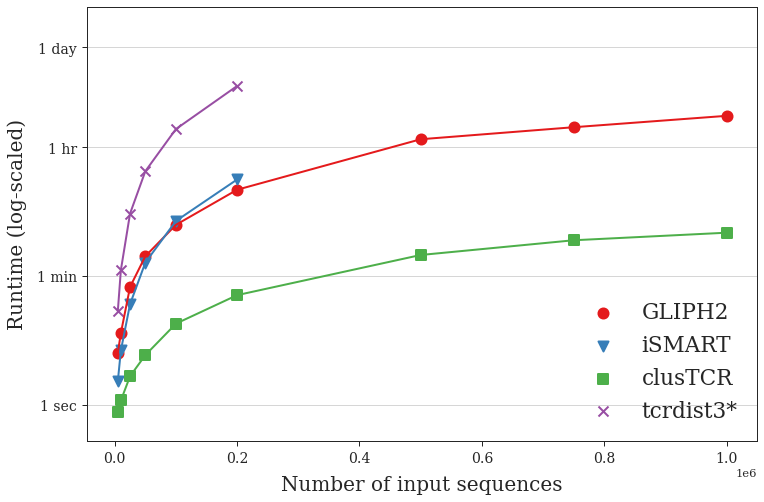

In [61]:
methods = data.columns[:-1]
n_seq = data[data.columns[-1]].unique()
colors = ['tab:blue', 'tab:orange', '']
markers = ["o", "v", "s", "x"]

fig, ax = plt.subplots(figsize=(12,8))
for (method, marker) in zip(methods, markers):
    ax.scatter(n_seq, y = np.log10(data.groupby(by='n_sequences').mean()[method]), 
               marker = marker, 
               s = 100, 
               linewidths = 2,  
               label = method,
               zorder = 1,
              )
    ax.plot(n_seq, np.log10(data.groupby(by='n_sequences').mean()[method]), 
            alpha = 1, 
            lw = 2,
            zorder = 2)

# ax.set_title('Speed of TCR clustering methods', fontsize = 32, y=1.04)
ax.set_xlabel('Number of input sequences', fontsize = 20, labelpad = 10)
ax.set_ylabel('Runtime (log-scaled)', fontsize = 20, labelpad = 10)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=8)
ax.legend(fontsize = 'xx-large')

locs = np.log10([1,60,3600,86400])
labels = ["1 sec", "1 min", "1 hr", "1 day"]
plt.ylim((-0.5,5.5))
plt.yticks(ticks=locs, labels=labels)
plt.grid(axis='y')

fig.savefig('results/figures/method_comparison_speed_log.eps', format='eps')